In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_csv('1_Merged_Data.csv')

In [3]:
#####################
# Check missing values

In [4]:
vars_with_missing = []

for f in df.columns:
    missings = df[f].isnull().sum() + len(df[df[f]=='MISSING'])
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable curnt_insurer has 859 records (34.98%) with missing values
Variable time_w_carr has 68 records (2.77%) with missing values
Variable prior_bi has 68 records (2.77%) with missing values
Variable veh_lien_cnt has 2451 records (99.80%) with missing values
Variable credit_score has 108 records (4.40%) with missing values
In total, there are 5 variables with missing values


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [5]:
df = df.drop(columns= ['veh_lien_cnt', 'curnt_insurer'])

In [6]:
df['credit_score'].fillna(df['credit_score'].mean(),inplace=True)
df['time_w_carr'].fillna(df['time_w_carr'].mode()[0],inplace=True)
df['prior_bi'].fillna(df['prior_bi'].mode()[0],inplace=True)

In [7]:
df['target'] =df['future_clm_ind']
df = df.drop(columns = ['future_clm_ind'])

In [8]:
########################
# Highly unbalanced data

0    2317
1     139
Name: target, dtype: int64

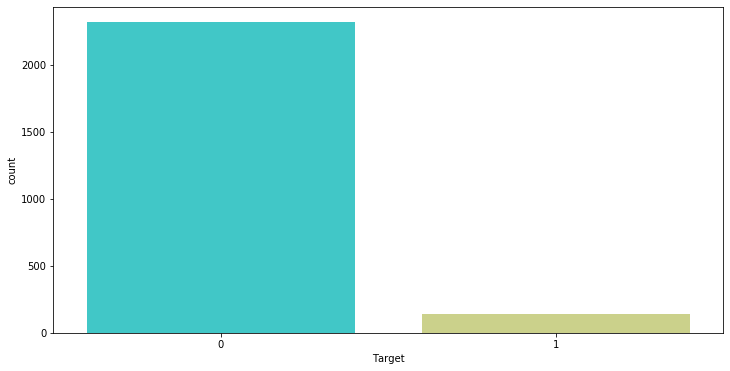

In [9]:

plt.figure(figsize=(12,6))
sns_plot = sns.countplot(df['target'],palette='rainbow')
plt.xlabel('Target')
plt.savefig("Generated_Image/unbalance.png")
df['target'].value_counts()

In [10]:
#############################
#Feature Selection

In [11]:
def basic_details(df):
    b = pd.DataFrame()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

In [12]:
basic_details(df)

,N unique value,dtype
hhld_id,2456,int64
drvr_cnt,4,int64
veh_cnt,4,int64
min_age,2305,float64
hoh_age,2394,float64
max_age,2395,float64
avg_age,2398,float64
min_mon_lic,2304,float64
hoh_mon_lic,2388,float64
max_mon_lic,2389,float64


In [13]:
sts = df[['min_age', 'max_age', 'avg_age', 'hoh_age', 'min_mon_lic','max_mon_lic',
      'avg_mon_lic', 'hoh_mon_lic', 'credit_score']].describe()
sts

,min_age,max_age,avg_age,hoh_age,min_mon_lic,max_mon_lic,avg_mon_lic,hoh_mon_lic,credit_score
count,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000
mean,39.666007,49.806955,45.290053,49.106970,282.231930,402.720549,348.333983,393.098567,667.090822
std,14.676530,14.917073,12.944450,14.787177,176.148466,180.529551,156.385212,179.063759,98.998311
min,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,0.000000,345.439379
25%,28.797552,40.105748,37.264964,39.614974,151.711600,285.624064,251.508585,276.394033,604.008896
50%,39.068094,50.979108,45.414963,50.216067,273.927099,418.816663,350.994134,406.795641,667.090822
75%,49.828708,60.478842,53.844861,59.507833,405.678484,531.683231,451.492407,519.364662,735.026403
max,105.513983,105.513983,105.513983,105.513983,1074.167791,1074.167791,1074.167791,1074.167791,850.000000


<Figure size 432x288 with 0 Axes>

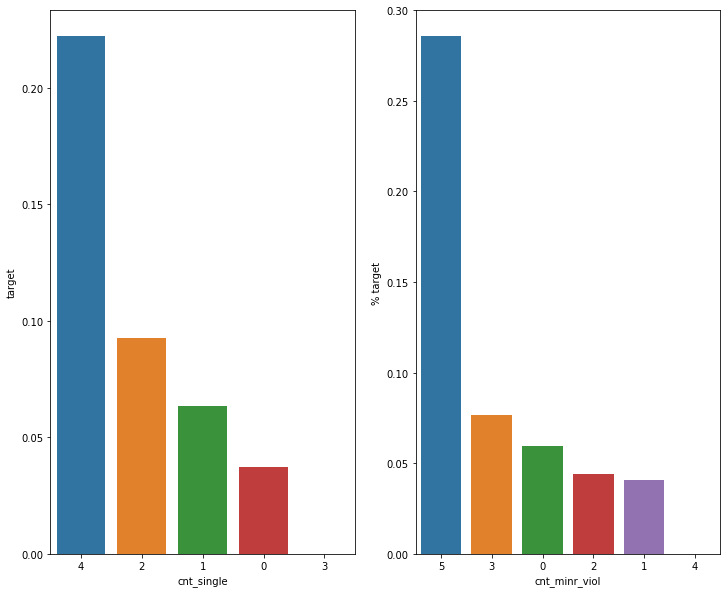

In [14]:
v = df[['cnt_single','cnt_minr_viol']]


plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,10))
    


    # Calculate the percentage of target=1 per category value
cat_perc_1 = df[['cnt_single', 'target']].groupby(['cnt_single'],as_index=False).mean()
cat_perc_1.sort_values(by='target', ascending=False, inplace=True)
cat_perc_2 = df[['cnt_minr_viol', 'target']].groupby(['cnt_minr_viol'],as_index=False).mean()
cat_perc_2.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
sns.barplot(ax=ax1, x='cnt_single', y='target', data=cat_perc_1, order=cat_perc_1['cnt_single'])
plt.ylabel('% target')
plt.xlabel('cnt_single')
sns.barplot(ax=ax2, x='cnt_minr_viol', y='target', data=cat_perc_2, order=cat_perc_2['cnt_minr_viol'])
plt.ylabel('% target')
plt.xlabel('cnt_minr_viol')
plt.tick_params(axis='both', which='major')
plt.savefig('Generated_Image/univariate_analysis')

plt.show();

In [15]:
############################
#Feature Selection with Random Forest 

In [16]:
X = df.drop(columns= ['hhld_id', 'target'])
y = df['target']

In [17]:
feat_labels = X.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
feat_labels = X.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X, y)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) credit_score                   0.299712
 2) prior_bi                       0.213952
 3) avg_mon_lic                    0.036105
 4) hoh_age                        0.034295
 5) avg_age                        0.033664
 6) hoh_mon_lic                    0.033290
 7) max_mon_lic                    0.033030
 8) min_mon_lic                    0.032749
 9) max_age                        0.032404
10) min_age                        0.031272
11) time_w_carr                    0.017038
12) curnt_bi_low                   0.009969
13) curnt_bi_upp                   0.009945
14) veh_own_cnt                    0.008691
15) cnt_male                       0.008475
16) drvr_cnt                       0.008232
17) cnt_female                     0.008153
18) cnt_single                     0.007838
19) cnt_minr_viol                  0.007764
20) cnt_auto                       0.007655
21) avg_minr_viol                  0.007624
22) naft_2016                      0.007528
23) naft_2014                   

In [19]:
num_features = ['min_age', 'max_age', 'avg_age', 'hoh_age', 'min_mon_lic','max_mon_lic',
      'avg_mon_lic', 'hoh_mon_lic', 'credit_score']
cat_features = ['drvr_cnt', 'veh_cnt', 
       'cnt_yth', 'cnt_female', 'cnt_male', 'cnt_married', 'cnt_single',
       'cnt_auto', 'cnt_mtrcyc', 'avg_majr_viol',
       'cnt_majr_viol', 'cnt_minr_viol', 'avg_minr_viol', 'cnt_lic_susp',
       'time_w_carr', 'prior_bi', 
       'veh_lease_cnt', 'veh_own_cnt', 'monthly_pay_ind',
       'veh_w_coll_cnt', 'veh_w_comp_cnt', 'veh_w_ers_cnt', 'curnt_bi_low',
       'curnt_bi_upp', 'naft_2012', 'naft_2013', 'naft_2014',
       'naft_2015', 'naft_2016', 'aft_2012', 'aft_2013', 'aft_2014',
       'aft_2015', 'aft_2016']
ind_features = ['hoh_married', 'inforce_ind','fire_ind', 'homeowner_ind']

In [20]:
#Correlation between interval variable

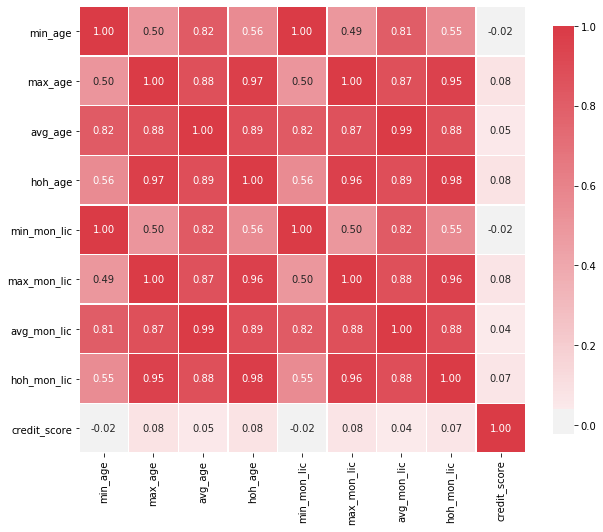

In [21]:
def corr_heatmap(v):
    correlations = df[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    


corr_heatmap(num_features)

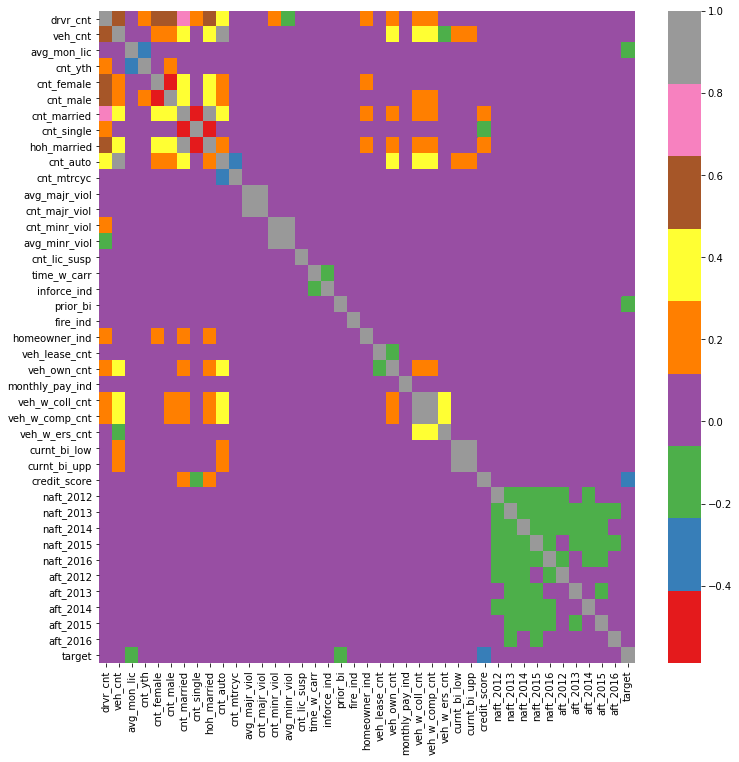

In [22]:
#Correlation plot
df_corr = df.drop(columns = ['hhld_id','min_age', 'max_age', 'avg_age', 'hoh_age',
                             'min_mon_lic','max_mon_lic','hoh_mon_lic'])
cor = df_corr.corr()
plt.figure(figsize=(12,12))
sns.heatmap(cor,cmap='Set1')
plt.savefig("Generated_Image/Correlation.png")

In [23]:
feature_selected = ['hhld_id','credit_score', 'prior_bi', 'avg_mon_lic', 'time_w_carr', 'curnt_bi_low', 'curnt_bi_upp',
                    'veh_own_cnt', 'cnt_male', 'drvr_cnt', 'cnt_female','target']

In [24]:
df = df[feature_selected]

In [25]:
def category_type(df):
    col = df.columns
    for i in col:
        if df[i].nunique()<=16:
            df[i] = df[i].astype('category')
category_type(df)

In [26]:
tot_cat_col = list(df.select_dtypes(include=['category']).columns)

In [27]:
def OHE(df, column):
    cat_col = column
    #cat_col = df.select_dtypes(include =['category']).columns
    len_df = df.shape[0]
    c2,c3 = [],{}
    
    print('Categorical feature',len(column))
    for c in cat_col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df, prefix=c3, columns=c2,drop_first=True)

    print('Train',df.shape)
    return df

In [28]:
train_1 = OHE(df,tot_cat_col)

Categorical feature 9
Train (2456, 37)


In [29]:
train_1.to_csv('2_Cleaned_Data_feature_selection.csv')